In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy
import time
import random

In [2]:
import os
data = datasets.MNIST(os.getcwd(), download=False)

Sat Apr 16 03:09:31 2022
Началась эпоха: 1
    001/468: tensor(0.1367, grad_fn=<MseLossBackward0>)
    ...
    234/468: tensor(0.0112, grad_fn=<MseLossBackward0>)
    ...
    468/468: tensor(0.0073, grad_fn=<MseLossBackward0>)
Эпоха длилась: 00:01:28
-------------------------------------------------------
Всё обучение заняло: 00:01:28


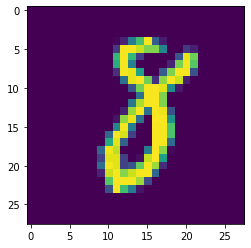

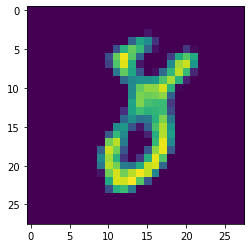

In [3]:

#hyper params
num_epoch = 1
cuda_device = -1
batch_size = 128
device = f'cuda:{cuda_device}' if cuda_device != -1 else 'cpu'
# input_dimension = 28*28
# hidden_dimension = 14*14
# latent_dimension = 7*7

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


def collate_fn(data):
    pics = []
    targets = []
    # data = [(pic, target), ....]
    for item in data:
        pics.append(numpy.array(item[0]))
        targets.append(item[1])
    return {
        'data': torch.from_numpy(numpy.array(pics)) / 255,
        'target': torch.from_numpy(numpy.array(targets))
    }

#model
class MyMNISTEncoder(nn.Module):
    def __init__(self,
                 in_channel: int,
                 hidden_channel: int,
                 ):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channel, hidden_channel, kernel_size=5, padding=2, stride=1) # 28 x 28
        self.bn1 = nn.BatchNorm2d(hidden_channel)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(hidden_channel, hidden_channel, kernel_size=3, padding=1, stride=1) # 14 x 14
        self.bn2 = nn.BatchNorm2d(hidden_channel)
        self.pool2 = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(hidden_channel, 1, kernel_size=3, padding=1, stride=1) # 7 x 7

        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.pool1(self.bn1(self.conv1(x))))
        x = self.activation(self.pool2(self.bn2(self.conv2(x))))
        x = self.activation(self.conv3(x))

        return x

class MyMNISTDecoder(nn.Module):
    def __init__(self,
                 in_channel: int,
                 hidden_channel: int,
                 ):
        super().__init__()
        self.conv1 = nn.Conv2d(1, hidden_channel, kernel_size=5, padding=2, stride=1) # 7 x 7
        self.bn1 = nn.BatchNorm2d(hidden_channel)
        self.unpool1 = nn.UpsamplingNearest2d(scale_factor=2)
        self.conv2 = nn.Conv2d(hidden_channel, hidden_channel, kernel_size=3, padding=1, stride=1) # 14 x 14
        self.bn2 = nn.BatchNorm2d(hidden_channel)
        self.unpool2 = nn.UpsamplingNearest2d(scale_factor=2)
        self.conv3 = nn.Conv2d(hidden_channel, in_channel, kernel_size=3, padding=1, stride=1) # 28 x 28

        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.unpool1(self.bn1(self.conv1(x))))
        x = self.activation(self.unpool2(self.bn2(self.conv2(x))))
        x = self.activation(self.conv3(x))

        return x

class MyAutoEncoder(nn.Module):
    def __init__(self,
                 input_dimension,
                 hidden_dimension,
                 ):
        super().__init__()
        self.encoder = MyMNISTEncoder(input_dimension, hidden_dimension)
        self.decoder = MyMNISTDecoder(input_dimension, hidden_dimension)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x


# init model
model = MyAutoEncoder(1, 50)
model.train()
model.to(device)

#optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.001)

#lr scheduler

#dataset
dataset = datasets.MNIST(os.getcwd(), download=False)

#loss
loss_func = nn.MSELoss()


# train loop
time_start = time.time()
len_dl = len(DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True,))
print(time.ctime())
for epoch in range(num_epoch):
    #dataloder
    data_loader = DataLoader(dataset=dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             collate_fn=collate_fn,
                             drop_last=True,
                             )
    time_start_epoch = time.time()
    print('Началась эпоха: ' + str(epoch+1))
    for i, batch in enumerate(data_loader):
        data = batch['data'].to(device).unsqueeze(1)
        optim.zero_grad()
        predict = model(data)
        # print(data.size())
        # print(predict.size())
        loss = loss_func(predict, data)
        loss.backward()
        optim.step()
        if i == 0 or i == len(data_loader)//2 - 1:
            print('    ' + f'{i+1:0{len(str(len_dl))}}' + '/' + str(len_dl) + ': ' + str(loss))
            print('    ...')
        elif i == len(data_loader) - 1:
            print('    ' + f'{i+1:0{len(str(len_dl))}}' + '/' + str(len_dl) + ': ' + str(loss))
    print('Эпоха длилась: ' + time.strftime('%H:%M:%S', time.gmtime(time.time() - time_start_epoch)))
    print('-------------------------------------------------------')

print('Всё обучение заняло: ' + time.strftime('%H:%M:%S', time.gmtime(time.time() - time_start)))


id = 784
test = dataset.data[id].unsqueeze(0).unsqueeze(0).float() / 255
# test.size()
predict = model(test)
plt.imshow(dataset.data[id].float() / 255)
plt.show()
plt.imshow(predict[0][0].detach().numpy())
plt.show()

Sat Apr 16 03:11:00 2022
Началась эпоха: 1
    001/600: tensor(0.8811, grad_fn=<AddBackward0>)
    ...
    300/600: tensor(0.3003, grad_fn=<AddBackward0>)
    ...
    600/600: tensor(0.2951, grad_fn=<AddBackward0>)
Эпоха длилась: 00:04:42
-------------------------------------------------------
Всё обучение заняло: 00:04:42


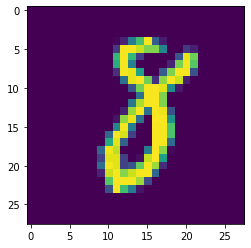

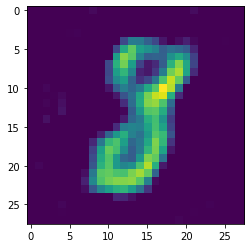

In [4]:

#hyper params

cuda_device = -1
batch_size = 100
device = f'cuda:{cuda_device}' if cuda_device != -1 else 'cpu'


seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

test_bn = []

def collate_fn(data):
    pics = []
    targets = []
    for item in data:
        pics.append(numpy.array(item[0]))
        targets.append(item[1])
    return {
        'data': torch.from_numpy(numpy.array(pics)) / 255,
        'target': torch.from_numpy(numpy.array(targets))
    }

#model
class MyMNISTEncoder(nn.Module):
    def __init__(self,
                 in_channel: int,
                 hidden_channel: int,
                 ):
        super().__init__()
        # 100*1*28*28 -> 100*50*28*28
        self.conv1 = nn.Conv2d(in_channel, hidden_channel, kernel_size=5, padding=2, stride=1) # 28 x 28
        self.batn1 = nn.BatchNorm2d(hidden_channel)
        # 100*50*28*28 -> 100*50*14*14
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(hidden_channel, hidden_channel, kernel_size=3, padding=1, stride=1) # 14 x 14
        self.batn2 = nn.BatchNorm2d(hidden_channel)
        # 100*50*14*14 -> 100*50*7*7
        self.pool2 = nn.MaxPool2d(2,2)
        # 100*50*7*7 -> 100*50*7*7
        self.conv3 = nn.Conv2d(hidden_channel, hidden_channel, kernel_size=3, padding=1, stride=1) # 7 x 7
        # self.batn3 = nn.BatchNorm2d(hidden_channel)
        self.lin = nn.Linear(hidden_channel*7*7, hidden_channel*7*7)
        # 100*50*7*7 -> 100*2450
        # 100*2450 -> 100*490
        self.lin_mu = nn.Linear(hidden_channel*7*7, hidden_channel*7*7)
        self.lin_si = nn.Linear(hidden_channel*7*7, hidden_channel*7*7)

        self.conv_mu = nn.Conv2d(hidden_channel*2, 1, kernel_size=3, padding=1, stride=1) # 7 x 7
        self.conv_si = nn.Conv2d(hidden_channel*2, 1, kernel_size=3, padding=1, stride=1) # 7 x 7
        # nn.Sequential()
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.pool1(self.batn1(self.conv1(x))))
        x = self.activation(self.pool2(self.batn2(self.conv2(x))))
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.lin(x)
        mu = self.activation(x)
        si = torch.sigmoid(x)

        return mu, si

class MyMNISTDecoder(nn.Module):
    def __init__(self,
                 in_channel: int,
                 hidden_channel: int,
                 ):
        super().__init__()
        self.line1 = nn.Linear(hidden_channel*7*7, hidden_channel*7*7)
        self.batn0 = nn.BatchNorm1d(hidden_channel*7*7)
        self.conv1 = nn.ConvTranspose2d(hidden_channel, hidden_channel, kernel_size=3, padding=1, stride=1) # 7 x 7
        self.batn1 = nn.BatchNorm2d(hidden_channel)
        self.unpl1 = nn.UpsamplingNearest2d(scale_factor=2)
        self.conv2 = nn.ConvTranspose2d(hidden_channel, hidden_channel, kernel_size=3, padding=1, stride=1) # 14 x 14
        self.batn2 = nn.BatchNorm2d(hidden_channel)
        self.unpl2 = nn.UpsamplingNearest2d(scale_factor=2)
        self.conv3 = nn.ConvTranspose2d(hidden_channel, in_channel, kernel_size=3, padding=1, stride=1) # 28 x 28
        self.batn3 = nn.BatchNorm2d(in_channel)

        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.line1(x))
        x = x.view(x.size(0), -1).unsqueeze(-1).unsqueeze(-1)
        x = x.view(x.size(0), -1, 7, 7)
        x = self.batn1(self.conv1(x))
        x = self.activation(self.unpl1(x))
        x = self.batn2(self.conv2(x))
        x = self.activation(self.unpl2(x))
        x = self.activation(self.batn3(self.conv3(x)))

        return x

def sampling(mu, sigma):
    return mu + sigma * torch.normal(torch.zeros_like(mu), torch.ones_like(mu))

class MyAutoEncoder(nn.Module):
    def __init__(self,
                 input_dimension,
                 hidden_dimension,
                 ):
        super().__init__()
        self.encoder = MyMNISTEncoder(input_dimension, hidden_dimension)
        self.decoder = MyMNISTDecoder(input_dimension, hidden_dimension)

    def forward(self, x):
        mu, sigma = self.encoder(x)
        x = self.decoder(sampling(mu, sigma))

        return x, mu, sigma

def kl_loss(mu, sigma):
    p = torch.distributions.Normal(mu, sigma)
    q = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(sigma))

    return torch.distributions.kl_divergence(p, q).mean()

# init model
model = MyAutoEncoder(1, 50)
model.train()
model.to(device)

#optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.001)

#lr scheduler

#dataset
dataset = datasets.MNIST(os.getcwd(), download=False)

#loss
criterion = nn.MSELoss()


# train loop
num_epoch = 1
time_start = time.time()
len_dl = len(DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True,))
print(time.ctime())
for epoch in range(num_epoch):
    #dataloder
    data_loader = DataLoader(dataset=dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             collate_fn=collate_fn,
                             drop_last=True,
                             )
    time_start_epoch = time.time()
    print('Началась эпоха: ' + str(epoch+1))
    for i, batch in enumerate(data_loader):
        data = batch['data'].to(device).unsqueeze(1)
        optim.zero_grad()
        predict, mu, sigma = model(data)
        loss = kl_loss(mu, sigma) + criterion(data, predict)
        loss.backward()
        optim.step()
        if i == 0 or i == len(data_loader)//2 - 1:
            print('    ' + f'{i+1:0{len(str(len_dl))}}' + '/' + str(len_dl) + ': ' + str(loss))
            print('    ...')
        elif i == len(data_loader) - 1:
            print('    ' + f'{i+1:0{len(str(len_dl))}}' + '/' + str(len_dl) + ': ' + str(loss))
    print('Эпоха длилась: ' + time.strftime('%H:%M:%S', time.gmtime(time.time() - time_start_epoch)))
    print('-------------------------------------------------------')

print('Всё обучение заняло: ' + time.strftime('%H:%M:%S', time.gmtime(time.time() - time_start)))


id = 784
test = dataset.data[id].unsqueeze(0).unsqueeze(0).float() / 255
predict = model(test)
plt.imshow(dataset.data[id].float() / 255)
plt.show()
plt.imshow(predict[0][0][0].detach().numpy())
plt.show()